In [2]:
# Cell 1: Installations (MODIFIED)

# We specify a version of pyroomacoustics that is 0.6.0 or newer
!pip install pyroomacoustics>=0.6.0 -q 

!pip install pesq -q
!pip install pystoi -q
!pip install ptflops -q
!pip install torch-audiomentations -q

In [4]:
# Cell 2: Imports
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import librosa
from scipy.signal import butter, lfilter
import pyroomacoustics as pra
from tqdm.notebook import tqdm
import warnings

# For evaluation
from pesq import pesq

# For checking model complexity
from ptflops import get_model_complexity_info

# Suppress unnecessary warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Cell 3: Configuration
class Config:
    # Data paths based on your Kaggle input structure
    CSV_PATH = '/kaggle/input/fixed-data/dereverb_dataset_fixed.csv'
    CLEAN_ROOT = '/kaggle/input/clean-10/clean_10'
    REVERB_ROOT = '/kaggle/input/reverberant/reverberant_10'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Audio processing
    SAMPLE_RATE = 16000
    N_FFT = 1024
    HOP_LENGTH = 256
    # Training
    BATCH_SIZE = 8
    EPOCHS = 3  # Increased for better performance
    LEARNING_RATE = 1e-3
    
    # WPE Parameters
    WPE_TAPS = 10
    WPE_DELAY = 3
    WPE_ITERATIONS = 3
    
    # Model Parameters
    UNET_BASE_FILTERS = 16 # Keep this low for a small model
    UNET_LEVELS = 3        # Number of down/up sample stages

config = Config()

In [ ]:
# Cell 4: DSP Front-End Functions
import pyroomacoustics as pra

def highpass_filter(data, cutoff=80, fs=config.SAMPLE_RATE, order=5):
    """Applies a high-pass filter to the audio data."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data


def apply_wpe(audio_waveform):
    """Applies the WPE algorithm to a single-channel audio waveform."""
    audio_multichannel = audio_waveform[np.newaxis, :]
    
    try:
        # Import WPE from the new location
        from pyroomacoustics.wpe import wpe
        dereverb_audio = wpe(
            audio_multichannel,
            taps=config.WPE_TAPS,
            delay=config.WPE_DELAY,
            iterations=config.WPE_ITERATIONS
        ).squeeze()
        return dereverb_audio
    except (ImportError, np.linalg.LinAlgError):
        return audio_waveform  # fallback for silent audio or missing module


def preprocess_dsp(audio_waveform):
    """The full DSP chain: High-Pass -> WPE."""
    filtered_audio = highpass_filter(audio_waveform, fs=config.SAMPLE_RATE)
    dereverb_audio = apply_wpe(filtered_audio)
    return dereverb_audio

In [ ]:
# Cell 5: Tiny U-Net Model Definition

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class TinyUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_filters=16, levels=3):
        super().__init__()
        self.inc = ConvBlock(in_channels, base_filters)
        
        # Encoder (downsampling)
        self.encoders = nn.ModuleList()
        for i in range(levels):
            self.encoders.append(
                nn.Sequential(
                    nn.MaxPool2d(2),
                    ConvBlock(base_filters * (2**i), base_filters * (2**(i+1)))
                )
            )

        # Decoder (upsampling)
        self.decoders = nn.ModuleList()
        for i in range(levels):
            self.decoders.append(
                nn.ConvTranspose2d(base_filters * (2**(levels-i)), base_filters * (2**(levels-i-1)), kernel_size=2, stride=2)
            )
            self.decoders.append(
                ConvBlock(base_filters * (2**(levels-i)), base_filters * (2**(levels-i-1)))
            )
        
        self.outc = nn.Conv2d(base_filters, out_channels, kernel_size=1)
        self.levels = levels

    def forward(self, x):
        # The input spectrogram is (Batch, 1, Freq, Time)
        
        # Add a channel dimension if it's missing
        if x.dim() == 3:
            x = x.unsqueeze(1)
            
        x1 = self.inc(x)
        
        # Encoder path
        encoder_outputs = [x1]
        for i, encoder in enumerate(self.encoders):
            encoder_outputs.append(encoder(encoder_outputs[-1]))

        # Decoder path
        out = encoder_outputs[-1]
        for i in range(self.levels):
            # Upsample
            up = self.decoders[i*2](out)
            
            # Get skip connection from encoder
            skip_connection = encoder_outputs[-(i+2)]
            
            # Concatenate
            out = torch.cat([skip_connection, up], dim=1)
            
            # Convolution block
            out = self.decoders[i*2+1](out)

        # Final output layer
        # We predict a "mask" or a "residual" and add it to the input.
        # A final ReLU ensures the output is non-negative.
        residual = self.outc(out)
        return nn.ReLU()(x + residual)

In [ ]:
# Cell 6: The PyTorch Dataset Class

class ReverbDataset(Dataset):
    def __init__(self, csv_path, config, df):
        self.df = df
        self.config = config
        print(f"Loaded DataFrame with {len(self.df)} entries.")
        self._verify_paths()

    def _verify_paths(self):
        if len(self.df) == 0: return
        row = self.df.iloc[0]
        base_reverb_filename = os.path.basename(row['reverb_path'])
        expected_path = os.path.join(self.config.REVERB_ROOT, base_reverb_filename)
        if os.path.exists(expected_path):
            print(f"✅ Path verification successful. Found: {expected_path}")
        else:
            print(f"❌ Path verification FAILED. Could not find: {expected_path}")
            
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        base_reverb_filename = os.path.basename(row['reverb_path'])
        base_clean_filename = os.path.basename(row['clean_path'])
        
        reverb_path_kaggle = os.path.join(self.config.REVERB_ROOT, base_reverb_filename)
        clean_path_kaggle = os.path.join(self.config.CLEAN_ROOT, base_clean_filename)

        reverb_wav, _ = librosa.load(reverb_path_kaggle, sr=self.config.SAMPLE_RATE)
        clean_wav, _ = librosa.load(clean_path_kaggle, sr=self.config.SAMPLE_RATE)

        reverb_wav_processed = preprocess_dsp(reverb_wav)
        
        reverb_spec = librosa.stft(reverb_wav_processed, n_fft=self.config.N_FFT, hop_length=self.config.HOP_LENGTH)
        reverb_mag = np.abs(reverb_spec)
        
        clean_spec = librosa.stft(clean_wav, n_fft=self.config.N_FFT, hop_length=self.config.HOP_LENGTH)
        clean_mag = np.abs(clean_spec)
        
        reverb_phase = np.angle(reverb_spec)
        
        reverb_mag_t = torch.FloatTensor(reverb_mag)
        clean_mag_t = torch.FloatTensor(clean_mag)

        return {
            "reverb_mag": reverb_mag_t, "clean_mag": clean_mag_t,
            "reverb_phase": reverb_phase, "clean_wav": clean_wav
        }

In [67]:
# Cell 7: Model Training (MODIFIED)

# Load the main dataframe
main_df = pd.read_csv(config.CSV_PATH)

# Split data into training and validation (e.g., 90% train, 10% validation)
train_df = main_df.sample(frac=0.9, random_state=42)
val_df = main_df.drop(train_df.index)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# Create dataset instances
train_dataset = ReverbDataset(config.CSV_PATH, config, train_df)
val_dataset = ReverbDataset(config.CSV_PATH, config, val_df)

# Create dataloaders
# CHANGE THIS LINE vvvvvvvvvvvvvvvvv
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0)
# CHANGE THIS LINE vvvvvvvvvvvvvvvvv
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)


# Initialize model, loss, and optimizer
model = TinyUNet(base_filters=config.UNET_BASE_FILTERS, levels=config.UNET_LEVELS).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

print("\nStarting training...")
for epoch in range(config.EPOCHS):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS}")
    
    for batch in progress_bar:
        reverb_mags = batch['reverb_mag'].to(device).unsqueeze(1)
        clean_mags = batch['clean_mag'].to(device).unsqueeze(1)
        
        predicted_mags = model(reverb_mags)
        loss = criterion(predicted_mags, clean_mags)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{config.EPOCHS}, Average Training Loss: {avg_loss:.4f}")

print("Training finished.")
torch.save(model.state_dict(), "tinyunet_dereverb_final.pth")

Training samples: 900, Validation samples: 100
Loaded DataFrame with 900 entries.
✅ Path verification successful. Found: /kaggle/input/reverberant/reverberant_10/0521__M8s4__Crucif_508_2_RIR_reverb.wav
Loaded DataFrame with 100 entries.
✅ Path verification successful. Found: /kaggle/input/reverberant/reverberant_10/0001__M1s5__Lin8Ch_611_2_RIR_reverb.wav

Starting training...


Epoch 1/3: 100%|██████████| 113/113 [01:25<00:00,  1.31it/s, loss=0.122] 


Epoch 1/3, Average Training Loss: 0.1230


Epoch 2/3: 100%|██████████| 113/113 [01:26<00:00,  1.31it/s, loss=0.111] 


Epoch 2/3, Average Training Loss: 0.1112


Epoch 3/3: 100%|██████████| 113/113 [01:26<00:00,  1.30it/s, loss=0.0979]

Epoch 3/3, Average Training Loss: 0.1054
Training finished.


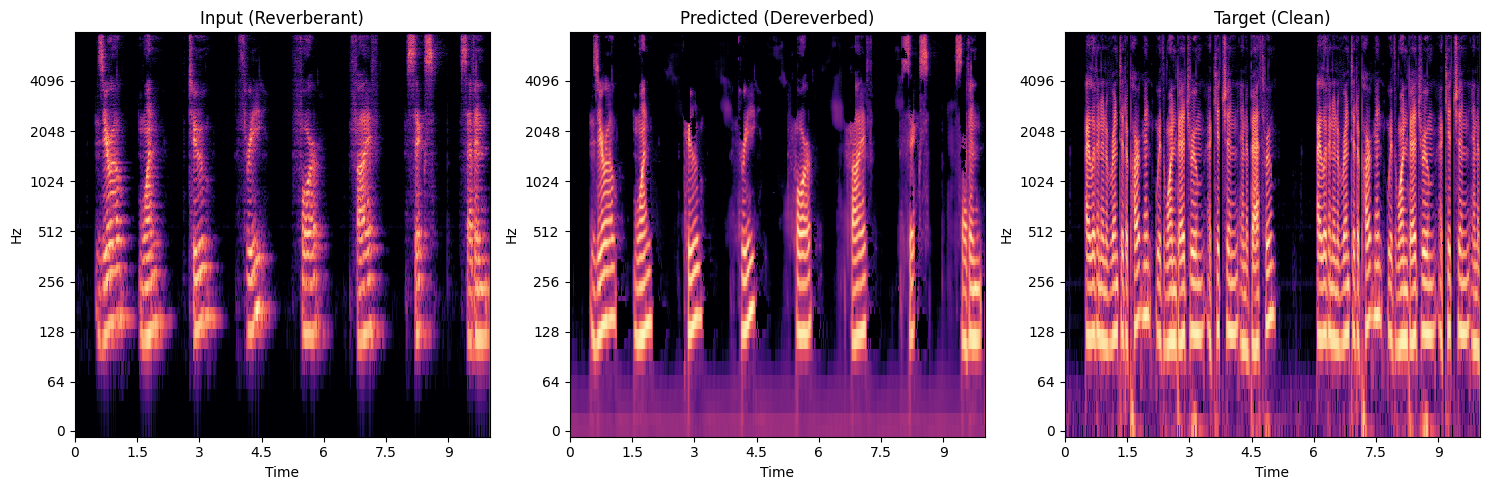

In [68]:
# Remove extra dimensions from predicted_mag
predicted_mag = np.squeeze(predicted_mag)

# Ensure correct orientation [freq, time]
if predicted_mag.ndim == 3:  # shape like (C, F, T)
    predicted_mag = predicted_mag[0]  # take first channel

# Same for input and clean
reverb_mag = np.squeeze(sample['reverb_mag'])
clean_mag = np.squeeze(clean_mag)

# Plot spectrograms
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
librosa.display.specshow(librosa.amplitude_to_db(reverb_mag, ref=np.max),
                         sr=config.SAMPLE_RATE, hop_length=config.HOP_LENGTH,
                         y_axis='log', x_axis='time')
plt.title("Input (Reverberant)")

plt.subplot(1,3,2)
librosa.display.specshow(librosa.amplitude_to_db(predicted_mag, ref=np.max),
                         sr=config.SAMPLE_RATE, hop_length=config.HOP_LENGTH,
                         y_axis='log', x_axis='time')
plt.title("Predicted (Dereverbed)")

plt.subplot(1,3,3)
librosa.display.specshow(librosa.amplitude_to_db(clean_mag, ref=np.max),
                         sr=config.SAMPLE_RATE, hop_length=config.HOP_LENGTH,
                         y_axis='log', x_axis='time')
plt.title("Target (Clean)")

plt.tight_layout()
plt.show()


In [69]:
import IPython.display as ipd

# --- Convert everything to NumPy safely ---
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

reverb_mag = np.squeeze(to_numpy(sample['reverb_mag']))
predicted_mag = np.squeeze(to_numpy(predicted_mag))
clean_mag = np.squeeze(to_numpy(clean_mag))

# --- Reconstruct audio from magnitude spectrograms ---
reverb_audio = librosa.griffinlim(reverb_mag, hop_length=config.HOP_LENGTH)
predicted_audio = librosa.griffinlim(predicted_mag, hop_length=config.HOP_LENGTH)
clean_audio = librosa.griffinlim(clean_mag, hop_length=config.HOP_LENGTH)

# --- Play audio ---
print("Original Reverberant Audio:")
ipd.display(ipd.Audio(reverb_audio, rate=config.SAMPLE_RATE))

print("Predicted Dereverberated Audio:")
ipd.display(ipd.Audio(predicted_audio, rate=config.SAMPLE_RATE))

print("Clean Ground Truth Audio:")
ipd.display(ipd.Audio(clean_audio, rate=config.SAMPLE_RATE))


Original Reverberant Audio:


Predicted Dereverberated Audio:


Clean Ground Truth Audio:


In [24]:
import IPython.display as ipd

# --- Convert everything to NumPy safely ---
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

reverb_mag = np.squeeze(to_numpy(sample['reverb_mag']))
predicted_mag = np.squeeze(to_numpy(predicted_mag))
clean_mag = np.squeeze(to_numpy(clean_mag))

# --- Reconstruct audio from magnitude spectrograms ---
reverb_audio = librosa.griffinlim(reverb_mag, hop_length=config.HOP_LENGTH)
predicted_audio = librosa.griffinlim(predicted_mag, hop_length=config.HOP_LENGTH)
clean_audio = librosa.griffinlim(clean_mag, hop_length=config.HOP_LENGTH)

# --- Play audio ---
print("Original Reverberant Audio:")
ipd.display(ipd.Audio(reverb_audio, rate=config.SAMPLE_RATE))

print("Predicted Dereverberated Audio:")
ipd.display(ipd.Audio(predicted_audio, rate=config.SAMPLE_RATE))

print("Clean Ground Truth Audio:")
ipd.display(ipd.Audio(clean_audio, rate=config.SAMPLE_RATE))


Original Reverberant Audio:


Predicted Dereverberated Audio:


Clean Ground Truth Audio:
